# **Solution of the Burger's equation using Physics-informed neural network via nnodely**

This tutorial implements the physics-informed neural network from appendix A of the paper titled:

*Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*

(available at https://doi.org/10.1016/j.jcp.2018.10.045)

This NN solves the Burger's equation

In [1]:
from nnodely import *
import numpy as np

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.2 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


Creation of the PINN network of the burger's equation

In [2]:
t = Input('t')
x = Input('x')
x_last = x.last()
t_last = t.last()

xt = Concatenate(x_last,t_last)
for hidden in range(4):
    xt = Tanh(Linear(20,  b = True, b_init = 'init_constant', b_init_params = {'value':0})(xt))
u = Linear(1, b = True, b_init = 'init_constant', b_init_params = {'value':0})(xt)

f = Differentiate(u,t_last) + Differentiate(u,x_last) * u - (0.01 / np.pi) * Differentiate(Differentiate(u,x_last),x_last)

U = Output('U',u)
F = Output('F',f)

Added two additional inputs to manage the boundary conditions

In [3]:
u_target = Input('u_target').last()
bound_cond = Input('b').last()

Creation of the Modely model of the PINN network

In [4]:
pinn = Modely(visualizer=TextVisualizer(), seed=42)
pinn.addModel('pinn',[U,F])
pinn.addMinimize('errorU',u * bound_cond, u_target * bound_cond)
pinn.addMinimize('errorF',f, bound_cond * 0)
pinn.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {'Constant18': {'dim': 1, 'values': [0.0031830989755690098]},
               'Constant23': {'dim': 1, 'values': [0.0]}},
 'Functions': {},
 'Info': {'SampleTime': 1,
          'nnodely_version': '1.5.2',
          'ns': [1, 0],
          'ntot': 1,
          'num_parameters': 1341},
 'Inputs': {'b': {'dim': 1, 'ns': [1, 0], 'ntot': 1, 'sw': [-1, 0]},
            't': {'dim': 1,
                  'ns': [1, 0],
                  'ntot': 1,
                  'sw': [-1, 0],
                  'type': 'derivate'},
            'u_target': {'dim': 1, 'ns': [1, 0], 'ntot': 1, 'sw': [-1, 0]},
            'x': {'dim': 1,
                  'ns': [1, 0],
                  'ntot': 1,
                  'sw': [-1, 0],
                  'type': 'derivate'}},
 'Minimizers': {'errorF': {'A': 'Sub22', 'B': 'Mul30', 'loss': 'mse'},
                'errorU': {'A': 'Mul27', 'B': 'Mul28', 'loss': 'mse'}},
 'Models':

Dataset Creation

In [5]:
import torch
# Create boundary conditions
Nu = 100
tt_0 = torch.zeros(Nu//2, dtype=torch.float32)
xx_0 = 2 * torch.rand(Nu//2, dtype=torch.float32) - 1
uu_0 = -torch.sin(torch.pi * xx_0)
b_0 = torch.ones(Nu//2, dtype=torch.float32)
#
tt_1 = torch.rand(Nu//4, dtype=torch.float32)
xx_1 = torch.ones(Nu//4, dtype=torch.float32)
uu_1 = torch.zeros(Nu//4, dtype=torch.float32)
b_1 = torch.ones(Nu//4, dtype=torch.float32)
#
tt_2 = torch.rand(Nu//4, dtype=torch.float32)
xx_2 = -torch.ones(Nu//4, dtype=torch.float32)
uu_2 = torch.zeros(Nu//4, dtype=torch.float32)
b_2 = torch.ones(Nu//4, dtype=torch.float32)
# Internal points
Nf = 10000
tt_3 = torch.rand(Nf, dtype=torch.float32)
xx_3 = 2 * torch.rand(Nf, dtype=torch.float32) - 1
uu_3 = torch.zeros(Nf, dtype=torch.float32)
b_3 = torch.zeros(Nf, dtype=torch.float32)

data = {'x':torch.cat((xx_0, xx_1, xx_2, xx_3)),
        't':torch.cat((tt_0, tt_1, tt_2, tt_3)),
        'u_target':torch.cat((uu_0, uu_1, uu_2, uu_3)),
        'b':torch.cat((b_0, b_1, b_2, b_3))}

Load the dataset and train the model

In [6]:
from nnodely.support import earlystopping
pinn.loadData('dataset2',data)
pinn.trainModel(train_dataset='dataset2', train_batch_size=128, num_of_epochs=5000, lr=0.0005, 
                minimize_gain={'errorU':1,'errorF':0.0005}, 
                early_stopping=earlystopping.early_stop_patience,  
                early_stopping_params={'patience':500, 'error':'errorU'}, 
                select_model=earlystopping.select_best_model)

============================ nnodely Model Dataset =============================
Dataset Name:                 dataset2
Number of files:              1
Total number of samples:      10100
Shape of b:                   (10100, 1, 1)
Shape of x:                   (10100, 1, 1)
Shape of t:                   (10100, 1, 1)
Shape of u_target:            (10100, 1, 1)
[_setup_recurrent_variables] The value of the prediction_samples=0 but the network has no recurrent variables.
======================== nnodely Model Train Parameters ========================
models:                       ['pinn']
num of epochs:                5000
update per epochs:            78
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'errorU', 'patience': 500}
train dataset:                dataset2
	- batch size:                128
	- num of samples:            10100
minimizers:                   {'errorF

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

Show the resulting network

[__call__] Inputs not provided: ['b', 'u_target']. Autofilling with zeros..
[__call__] Inputs not provided: ['b', 'u_target']. Autofilling with zeros..
[__call__] Inputs not provided: ['b', 'u_target']. Autofilling with zeros..
[__call__] Inputs not provided: ['b', 'u_target']. Autofilling with zeros..
[__call__] Inputs not provided: ['b', 'u_target']. Autofilling with zeros..
[__call__] Inputs not provided: ['b', 'u_target']. Autofilling with zeros..
[__call__] Inputs not provided: ['b', 'u_target']. Autofilling with zeros..
[__call__] Inputs not provided: ['b', 'u_target']. Autofilling with zeros..


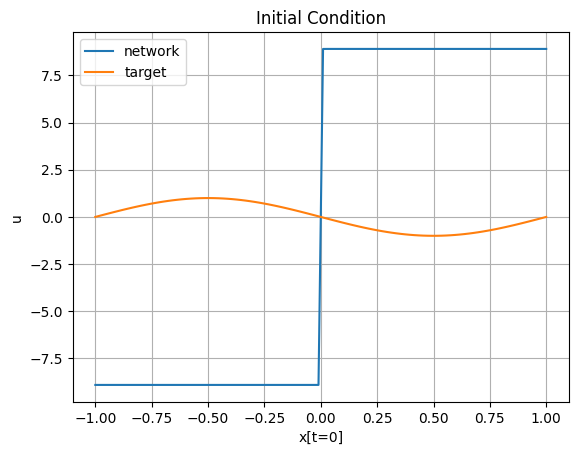

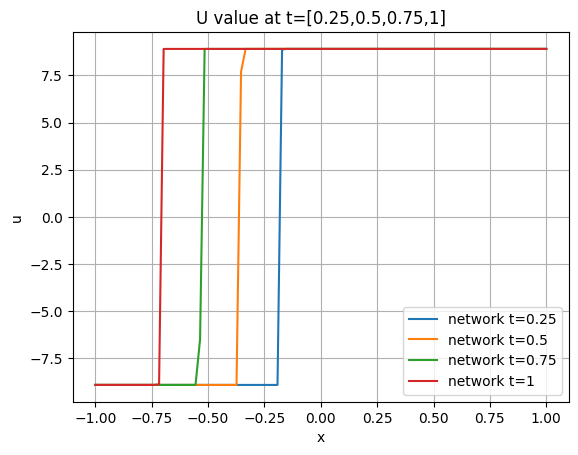

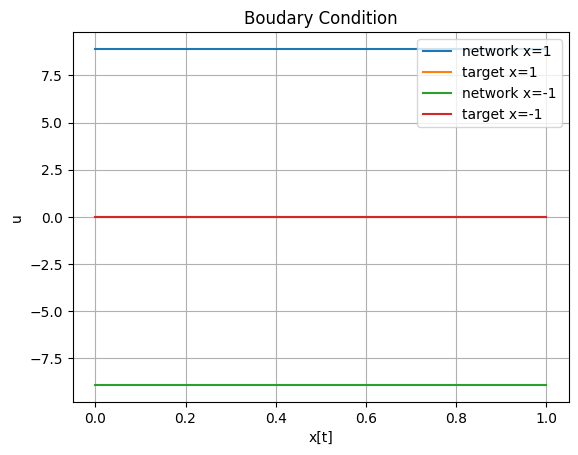

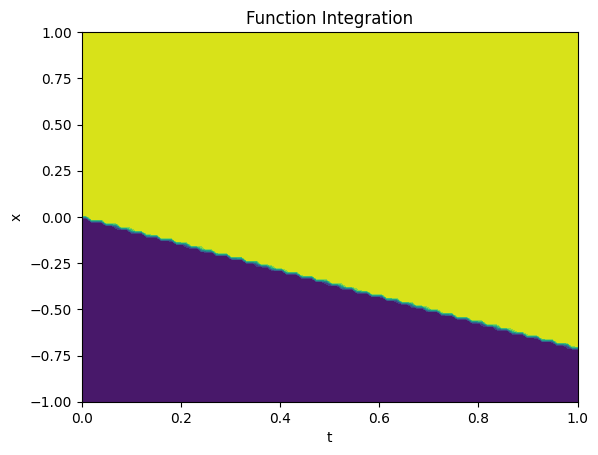

In [7]:
# Custom visualizer for results
class FunctionVisualizer(TextVisualizer):
    def showResults(self):
        import matplotlib.pyplot as plt
        plt.figure()
        plt.title('Initial Condition')
        x = torch.linspace(-1, 1, steps=100, dtype=torch.float32)
        t = torch.zeros(100, dtype=torch.float32)
        u_target = -torch.sin(torch.pi * x)
        u = self.modely({'x':x.tolist(),'t':t.tolist()})
        plt.plot(x.tolist(), u['U'], label=f'network')
        plt.plot(x.tolist(), u_target.tolist(), label=f'target')
        plt.grid(True)
        plt.legend(loc='best')
        plt.xlabel('x[t=0]')
        plt.ylabel('u')

        plt.figure()
        plt.title('U value at t=[0.25,0.5,0.75,1]')
        x = torch.linspace(-1, 1, steps=100, dtype=torch.float32)
        t = torch.ones(100, dtype=torch.float32)*0.25
        u = self.modely({'x':x.tolist(),'t':t.tolist()})
        plt.plot(x.tolist(), u['U'], label=f'network t=0.25')
        x = torch.linspace(-1, 1, steps=100, dtype=torch.float32)
        t = torch.ones(100, dtype=torch.float32)*0.5
        u = self.modely({'x':x.tolist(),'t':t.tolist()})
        plt.plot(x.tolist(), u['U'], label=f'network t=0.5')
        x = torch.linspace(-1, 1, steps=100, dtype=torch.float32)
        t = torch.ones(100, dtype=torch.float32)*0.75
        u = self.modely({'x':x.tolist(),'t':t.tolist()})
        plt.plot(x.tolist(), u['U'], label=f'network t=0.75')
        x = torch.linspace(-1, 1, steps=100, dtype=torch.float32)
        t = torch.ones(100, dtype=torch.float32)
        u = self.modely({'x':x.tolist(),'t':t.tolist()})
        plt.plot(x.tolist(), u['U'], label=f'network t=1')
        plt.grid(True)
        plt.legend(loc='best')
        plt.xlabel('x')
        plt.ylabel('u')

        plt.figure()
        plt.title('Boudary Condition')
        t_1 = torch.linspace(0, 1, steps=100, dtype=torch.float32)
        x_1 = torch.ones(100, dtype=torch.float32)
        u_1_target = torch.zeros(100, dtype=torch.float32)
        u_1 = self.modely({'x': x_1.tolist(), 't': t_1.tolist()})
        plt.plot(t_1.tolist(), u_1['U'], label=f'network x=1')
        plt.plot(t_1.tolist(), u_1_target.tolist(), label=f'target x=1')
        t_2 = torch.linspace(0, 1, steps=100, dtype=torch.float32)
        x_2 = -torch.ones(100, dtype=torch.float32)
        u_2_target = torch.zeros(100, dtype=torch.float32)
        u_2 = self.modely({'x': x_2.tolist(), 't': t_2.tolist()})
        plt.plot(t_2.tolist(), u_2['U'], label=f'network x=-1')
        plt.plot(t_2.tolist(), u_2_target.tolist(), label=f'target x=-1')
        plt.grid(True)
        plt.legend(loc='best')
        plt.xlabel('x[t]')
        plt.ylabel('u')

        plt.figure()
        plt.title('Function Integration')
        t_3 = torch.linspace(0, 1, steps=100, dtype=torch.float32).numpy()
        x_3 = torch.linspace(-1, 1, steps=100, dtype=torch.float32).numpy()
        T, X = np.meshgrid(t_3, x_3)
        u_2 = self.modely({'x': X.flatten().tolist(), 't': T.flatten().tolist()})
        plt.contourf(T, X, np.array(u_2['U']).reshape(100,100))
        plt.xlabel('t')
        plt.ylabel('x')
        plt.show()

res = FunctionVisualizer()
res.setModely(pinn)
res.showResults()